In [5]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download veeralakrishna/butterfly-dataset

 98% 447M/454M [00:03<00:00, 128MB/s]
100% 454M/454M [00:03<00:00, 130MB/s]


In [7]:
! unzip butterfly-dataset.zip &> /dev/null

In [8]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.9 MB/s eta 0:00:00


In [9]:
from torchvision import transforms

In [10]:
import torch
import torchvision
import torchvision.transforms as T

In [11]:
transform = T.Resize((256, 256))

(-0.5, 255.5, 255.5, -0.5)

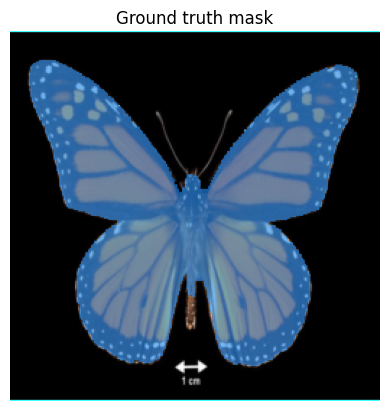

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

image = transform(Image.open('/content/leedsbutterfly/images/0010002.png'))
label = transform(Image.open('/content/leedsbutterfly/segmentations/0010002_seg0.png'))

axes.imshow(np.array(image))
ground_truth_seg = np.array(label)
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [13]:
ground_truth_seg.shape

(256, 256)

In [14]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [15]:
label = Image.open('/content/leedsbutterfly/segmentations/0010039_seg0.png')
ground_truth_seg = np.array(label)
testing = get_bounding_box(ground_truth_seg)

In [16]:
import os
seg_dir_list = os.listdir('/content/leedsbutterfly/segmentations')
img_dir_list = os.listdir('/content/leedsbutterfly/images')

In [17]:
data = []
for i in range(0, 832):
  img_temp = img_dir_list[i]
  for segitem in seg_dir_list:
    if(segitem.startswith(img_temp.split('.')[0])):
      data.append({'img':img_dir_list[i],'seg':segitem})
print(data)

[{'img': '0090038.png', 'seg': '0090038_seg0.png'}, {'img': '0050068.png', 'seg': '0050068_seg0.png'}, {'img': '0060166.png', 'seg': '0060166_seg0.png'}, {'img': '0070086.png', 'seg': '0070086_seg0.png'}, {'img': '0080054.png', 'seg': '0080054_seg0.png'}, {'img': '0040033.png', 'seg': '0040033_seg0.png'}, {'img': '0080002.png', 'seg': '0080002_seg0.png'}, {'img': '0090096.png', 'seg': '0090096_seg0.png'}, {'img': '0070001.png', 'seg': '0070001_seg0.png'}, {'img': '0020119.png', 'seg': '0020119_seg0.png'}, {'img': '0060039.png', 'seg': '0060039_seg0.png'}, {'img': '0070069.png', 'seg': '0070069_seg0.png'}, {'img': '0080013.png', 'seg': '0080013_seg0.png'}, {'img': '0010009.png', 'seg': '0010009_seg0.png'}, {'img': '0010001.png', 'seg': '0010001_seg0.png'}, {'img': '0010048.png', 'seg': '0010048_seg0.png'}, {'img': '0020115.png', 'seg': '0020115_seg0.png'}, {'img': '0090087.png', 'seg': '0090087_seg0.png'}, {'img': '0060038.png', 'seg': '0060038_seg0.png'}, {'img': '0080047.png', 'seg': 

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = transform(Image.open("/content/leedsbutterfly/images/" + item["img"]))
    ground_truth_mask = np.array(transform(Image.open(("/content/leedsbutterfly/segmentations/" + item["seg"]))))

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [20]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [21]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

In [22]:
train_dataset = SAMDataset(dataset=data, processor=processor)

In [23]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [30]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [31]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [32]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [33]:
!pip install -q monai

In [34]:
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [35]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [36]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 4

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 416/416 [07:16<00:00,  1.05s/it]


EPOCH: 0
Mean loss: 0.15573133220179722


100%|██████████| 416/416 [07:07<00:00,  1.03s/it]


EPOCH: 1
Mean loss: 0.11248060065106703


100%|██████████| 416/416 [07:07<00:00,  1.03s/it]


EPOCH: 2
Mean loss: 0.10053720626120384


100%|██████████| 416/416 [07:06<00:00,  1.02s/it]

EPOCH: 3
Mean loss: 0.0893609390522425


In [37]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 23

# load image
image = data[idx]["img"]
image = transform(Image.open("/content/leedsbutterfly/images/" + image))

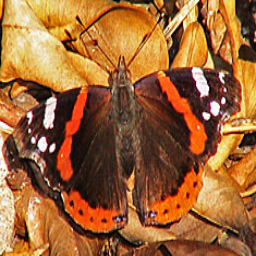

In [38]:
image

In [39]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(transform(Image.open("/content/leedsbutterfly/segmentations/" + data[idx]["seg"])))
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [40]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [41]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

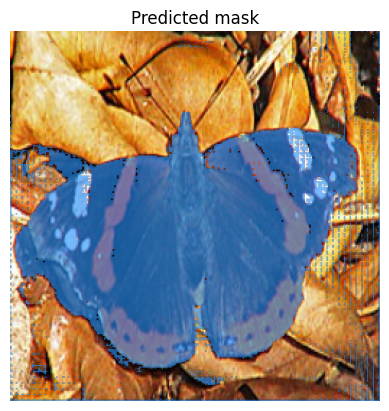

In [42]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

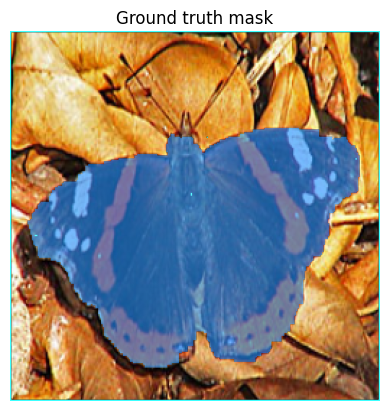

In [43]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")